# Zonal energy spectra (Figure 9)

In [1]:
import xarray as xr
from dask.diagnostics import ProgressBar

In [2]:
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
run = 'nw2_0.03125deg_N15_baseline_hmix20'
path = '/glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/'
chunks = {'time': 1}

In [4]:
st = xr.open_dataset('%s/%s/static.nc' %(path, run), decode_times=False, chunks=chunks)

In [5]:
av = xr.open_mfdataset('%s/%s/averages_*.nc' % (path, run), decode_times=False, chunks=chunks, combine='by_coords')

### Pick 500 days (i.e., 100 time slices) of data
Consistent with time interval considered in the remainder of this work

In [6]:
av = av.isel(time=slice(-100, None))
av.time

<xarray.DataArray 'time' (time: 100)>
array([2402.5, 2407.5, 2412.5, 2417.5, 2422.5, 2427.5, 2432.5, 2437.5, 2442.5,
       2447.5, 2452.5, 2457.5, 2462.5, 2467.5, 2472.5, 2477.5, 2482.5, 2487.5,
       2492.5, 2497.5, 2502.5, 2507.5, 2512.5, 2517.5, 2522.5, 2527.5, 2532.5,
       2537.5, 2542.5, 2547.5, 2552.5, 2557.5, 2562.5, 2567.5, 2572.5, 2577.5,
       2582.5, 2587.5, 2592.5, 2597.5, 2602.5, 2607.5, 2612.5, 2617.5, 2622.5,
       2627.5, 2632.5, 2637.5, 2642.5, 2647.5, 2652.5, 2657.5, 2662.5, 2667.5,
       2672.5, 2677.5, 2682.5, 2687.5, 2692.5, 2697.5, 2702.5, 2707.5, 2712.5,
       2717.5, 2722.5, 2727.5, 2732.5, 2737.5, 2742.5, 2747.5, 2752.5, 2757.5,
       2762.5, 2767.5, 2772.5, 2777.5, 2782.5, 2787.5, 2792.5, 2797.5, 2802.5,
       2807.5, 2812.5, 2817.5, 2822.5, 2827.5, 2832.5, 2837.5, 2842.5, 2847.5,
       2852.5, 2857.5, 2862.5, 2867.5, 2872.5, 2877.5, 2882.5, 2887.5, 2892.5,
       2897.5])
Coordinates:
  * time     (time) float64 2.402e+03 2.408e+03 ... 2.892e+03 2.898e+03
Attributes:
    long_name:       time
    units:           days since 0001-01-01 00:00:00
    cartesian_axis:  T
    calendar_type:   THIRTY_DAY_MONTHS
    calendar:        THIRTY_DAY_MONTHS
    bounds:          time_bnds

In [7]:
nr_days = 5 * len(av.time)
nr_days

500

### Compute missing grid information with xgcm

In [8]:
from xgcm import Grid
coords = {'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'}
         }

grid = Grid(st, coords=coords, periodic=['X'])

st['dxT'] = grid.interp(st.dxCu,'X')
st['dyT'] = grid.interp(st.dyCv,'Y')

### Assign x-coordinates in units of meters (rather than degrees)

In [10]:
xi = st['dxT'].cumsum(dim='xh') - st['dxT'].isel(xh=0) # subtract first dx so that we start at x = 0m

## Compute spectra 

In [11]:
import xrft
import numpy as np

In [12]:
# surface velocities
u = grid.interp(av.SSU, axis='X')
v = grid.interp(av.SSV, axis='Y')

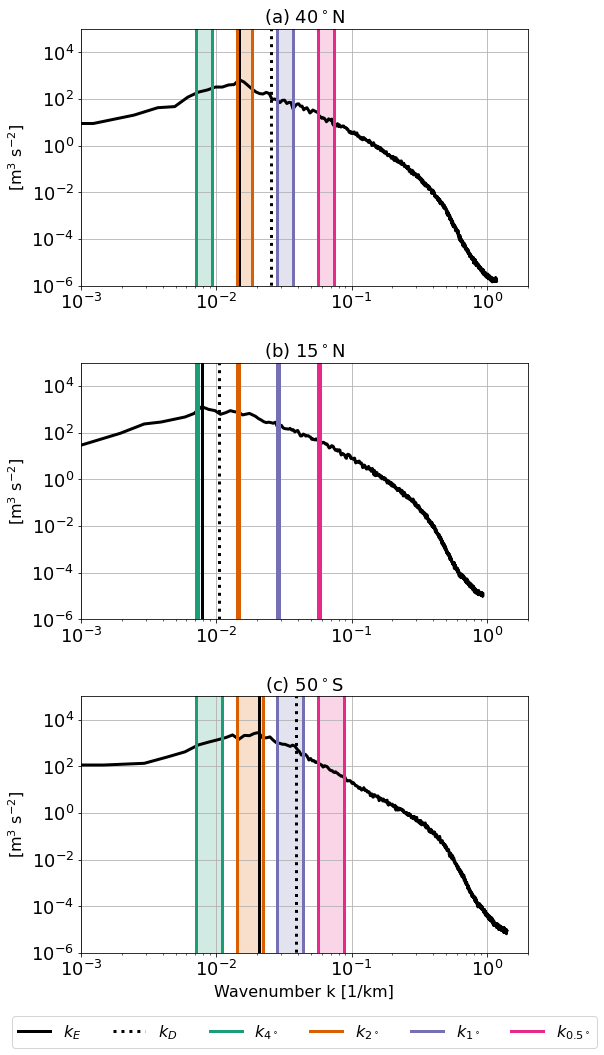

In [14]:
# compute zonal spectra at the following 3 latitudes
lat_list = [40, 15, -50]  
window_list = ['hann', 'hann', 'hann']  # we don't need tapering at 50S because here domain is periodic
lat_lb_list= [r'(a) 40$^\circ$N', r'(b) 15$^\circ$N', r'(c) 50$^\circ$S']

# for reference: 4 vertical lines corresponding to filter scales
filter_factors = [128, 64, 32, 16]
label_list = [r'$k_{4^\circ}$', r'$k_{2^\circ}$', r'$k_{1^\circ}$', r'$k_{0.5^\circ}$']
color_list = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']

fig, axs = plt.subplots(3,1, figsize=(8, 17))

for lat, lat_lb, window, ax in zip(lat_list, lat_lb_list, window_list, axs):
    xline = xi.sel(yh=lat, method='nearest')
        
    uline = u.sel(yh=lat, method='nearest').fillna(0.)
    uline = uline.assign_coords(xh=xline) 
    
    vline = v.sel(yh=lat, method='nearest').fillna(0.)
    vline = vline.assign_coords(xh=xline) 

    # use meridional eddy velocity v'
    vline= vline - vline.mean('time')
    
    viso2 = xrft.power_spectrum(vline, dim=['xh'], scaling="density", window='hann', detrend='linear').compute()
    ekeiso = .5*(viso2).mean('time') #Computing the mean spectrum
    nk = int(len(ekeiso)/2.)
    with ProgressBar():
        ekeiso = ekeiso.isel(freq_xh=slice(int(len(ekeiso.freq_xh) /2.), None)).compute() # just one half of the symmetric spectrum
    wavenumber = (ekeiso.freq_xh * 1000 * 2 * np.pi)  # convert cycles per m to wavenumber in 1/km
    ax.plot(wavenumber, ekeiso , linewidth=3, color='k')
    # spectrum peak
    max_ind = ekeiso.argmax().values
    max_wavenumber = wavenumber[max_ind]
    ax.plot([max_wavenumber, max_wavenumber], [1e-7,1e5], color='k', linewidth=3,label=r'$k_E$')

    # Rossby deformation scale
    # av.Rd1 is the Rossby "radius", where circumference / radius = 2 pi. As a result, we have the following analogies:
    # circumference <=> wavelength, radius <=> 2*pi/wavelength= 1/wavenumber; thus wavenumber = 1/Rd
    Ld_wavenumber = 1000 / (av.Rd1.sel(yh=lat, method='nearest').mean(dim=['time','xh'])).compute()
    ax.plot([Ld_wavenumber, Ld_wavenumber], [1e-7,1e5], color='k', linestyle='dotted', linewidth=3, label='$k_D$')
    
    # filter scales
    dx = st.dxT.sel(yh=lat, method='nearest').isel(xh=0).values
    dy = st.dyT.sel(yh=lat, method='nearest').isel(xh=0).values
    
    filter_dx_wavenumbers = []
    filter_dy_wavenumbers = []
    for factor in filter_factors:
        # in gcm-filters the Gaussian filter has a length scale qualitatively similar to a boxcar filter 
        # whose width (not radius) is equal to the filter_scale. If one considers the boxcar width to be 
        # the grid scale of the corresponding coarse model (which seems natural), then the Nyquist wavenumber 
        # for that coarse model would be pi / filter_scale, not 2 pi / filter_scale. As a result, the
        # connection between filter scale and wavenumber is defined by k = pi / filter_scale, i.e. the 
        # filter_scale is only half of a wavelength, not a full wavelength.
        filter_scale_x = factor * dx
        filter_scale_y = factor * dy
        
        filter_dx_wavenumbers.append(1000 * np.pi / filter_scale_x)  # in 1/km
        filter_dy_wavenumbers.append(1000 * np.pi / filter_scale_y)  # in 1/km
    for scale_dx, scale_dy, label, color in zip(filter_dx_wavenumbers, filter_dy_wavenumbers, label_list, color_list):
        ax.plot([scale_dx, scale_dx], [1e-7,1e5], color=color, linewidth=3, label=label)
        ax.plot([scale_dy, scale_dy], [1e-7,1e5], color=color, linewidth=3)
        
        ax.axvspan(scale_dy, scale_dx, color=color, alpha=0.2)

    ax.set_title(lat_lb, fontsize=18)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e-6, 1e5])
    ax.set_xlim([1e-3, 2e0])
    ax.set_xlabel('')
    ax.grid()
    ax.tick_params(labelsize=18);
    ax.set_ylabel(r'[m$^3$ s$^{-2}$]',fontsize=16)
axs[2].set_xlabel(r'Wavenumber k [1/km]',fontsize=16)
axs[2].legend(bbox_to_anchor=(0.5, -0.4), loc="lower center", fontsize=16, ncol=6)

plt.subplots_adjust(wspace=0.4, hspace=0.3)  

figname= 'figures/spectra.png' 
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)